# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.new_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.lp import lateness_scheduling as lp_late_schedule
from src.models.lp import lateness_rescheduling as lp_late_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*30     # 30 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der absoluten Lateness minimieren

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).

In [9]:
# Scheduling
df_schedule = lp_late_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, solver= "HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe absolute Lateness  : 0.0
  Solver-Status            : Optimal
  Anzahl Variablen         : 1392
  Anzahl Constraints       : 2592
  Laufzeit                 : ~3 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,0,M00,76,79,1440,3660,2886.0,2962.0,-698.0,698.0
1,J25-0000,8,1,M01,69,79,1440,3660,2962.0,3031.0,-629.0,629.0
2,J25-0000,8,2,M03,76,79,1440,3660,3031.0,3107.0,-553.0,553.0
3,J25-0000,8,3,M05,51,79,1440,3660,3129.0,3180.0,-480.0,480.0
4,J25-0000,8,4,M02,85,79,1440,3660,3239.0,3324.0,-336.0,336.0
5,J25-0000,8,5,M09,11,79,1440,3660,3345.0,3356.0,-304.0,304.0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,2020.0,2068.0,-913.0,913.0
155,J25-0015,5,5,M09,72,1436,1440,2981,2140.0,2212.0,-769.0,769.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2212.0,2259.0,-722.0,722.0


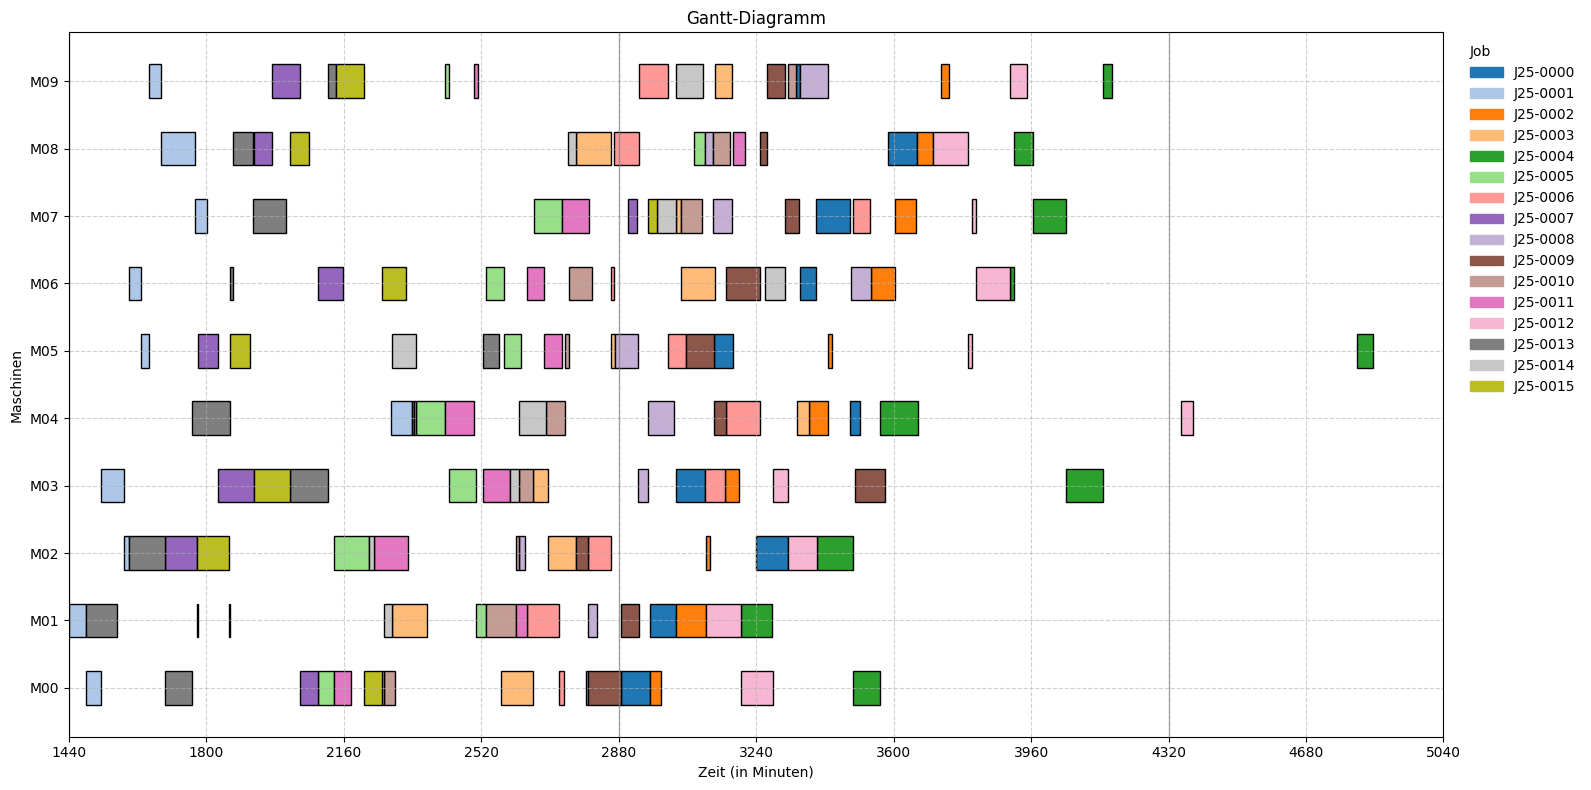

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [11]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0001 started on M01
[Day 1 00:38:00] Job J25-0001 finished on M01 (after 38 minutes)
[Day 1 00:46:00] Job J25-0013 started on M01
[Day 1 00:46:00] Job J25-0001 started on M00
[Day 1 01:21:00] Job J25-0001 finished on M00 (after 35 minutes)
[Day 1 01:23:00] Job J25-0001 started on M03
[Day 1 02:12:00] Job J25-0013 finished on M01 (after 86 minutes)
[Day 1 02:34:00] Job J25-0001 finished on M03 (after 71 minutes)
[Day 1 02:34:00] Job J25-0001 started on M02
[Day 1 02:45:00] Job J25-0001 finished on M02 (after 11 minutes)
[Day 1 02:45:00] Job J25-0013 started on M02
[Day 1 02:45:00] Job J25-0001 started on M06
[Day 1 03:17:00] Job J25-0001 finished on M06 (after 32 minutes)
[Day 1 03:17:00] Job J25-0001 started on M05
[Day 1 03:37:00] Job J25-0001 finished on M05 (after 20 minutes)
[Day 1 03:37:00] Job J25-0001 started on M09
[Day 1 04:14:00] Job J25-0001 finished on M09 (after 37 minutes)
[Day 1 04:14:00] Job J25-0001 started on M08
[Day 1 04:17:00] Job J25-0013 

In [12]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,6,J25-0001,0,M01,129,1440.0,38.0,1478.0
1,6,J25-0001,1,M00,129,1486.0,35.0,1521.0
2,6,J25-0001,2,M03,129,1523.0,71.0,1594.0
3,6,J25-0001,3,M02,129,1594.0,11.0,1605.0
4,6,J25-0001,4,M06,129,1605.0,32.0,1637.0
5,6,J25-0001,5,M05,129,1637.0,20.0,1657.0
...,...,...,...,...,...,...,...,...
74,5,J25-0015,3,M03,1436,1925.0,100.0,2025.0
75,5,J25-0015,4,M08,1436,2025.0,45.0,2070.0
76,5,J25-0015,5,M09,1436,2140.0,62.0,2202.0


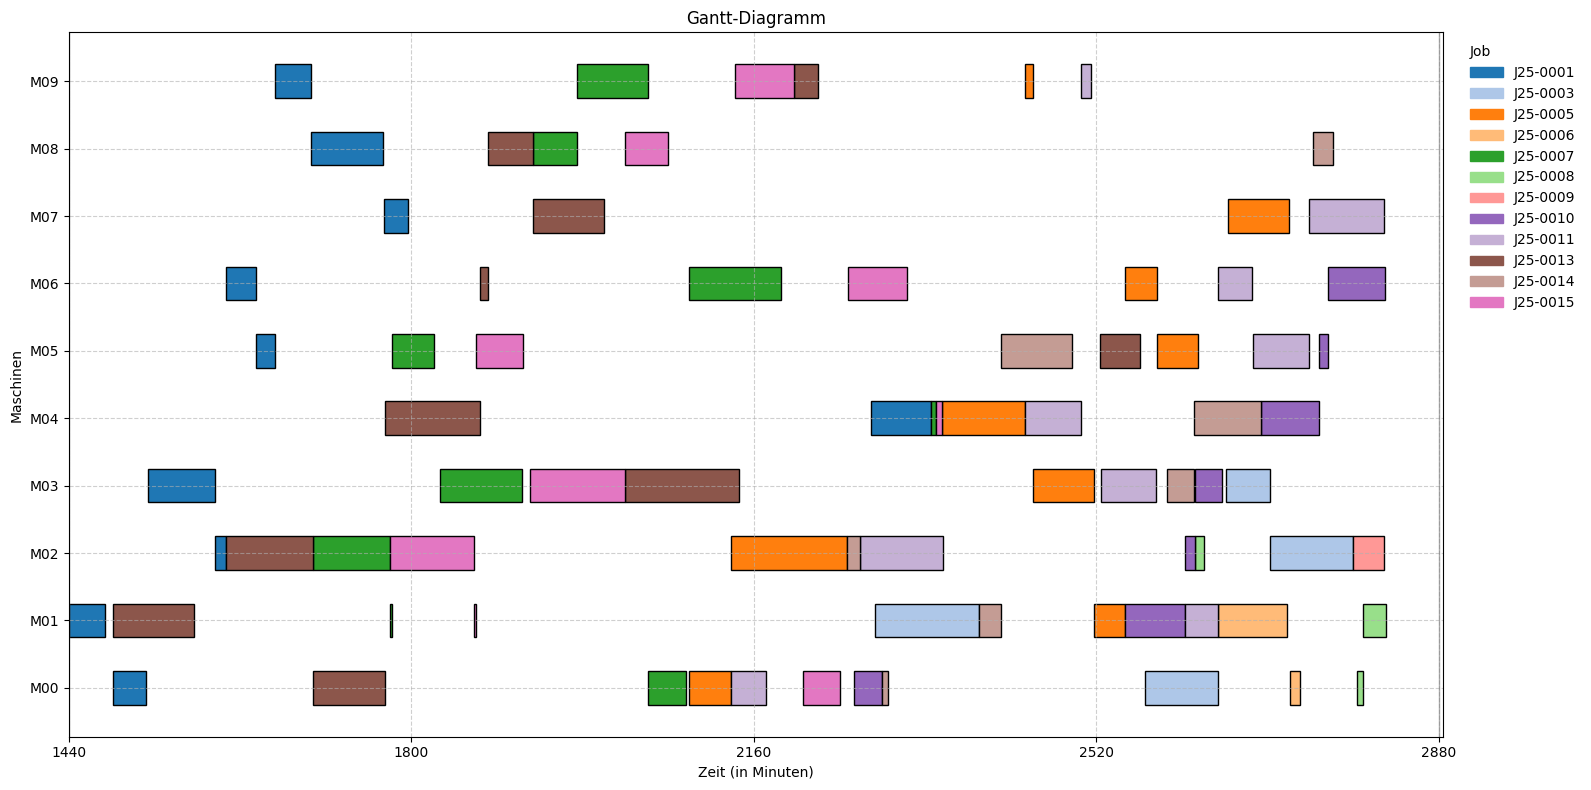

In [13]:
show.plot_gantt(df_execution, perspective="Machine")

In [14]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0003,4,M08,243,2790.0,90,95.0,2880.0,2885.0
1,J25-0006,2,M02,790,2822.0,61,64.0,2883.0,2886.0
2,J25-0008,3,M05,988,2869.0,61,58.0,2930.0,2927.0
3,J25-0009,1,M00,1004,2822.0,86,76.0,2908.0,2898.0


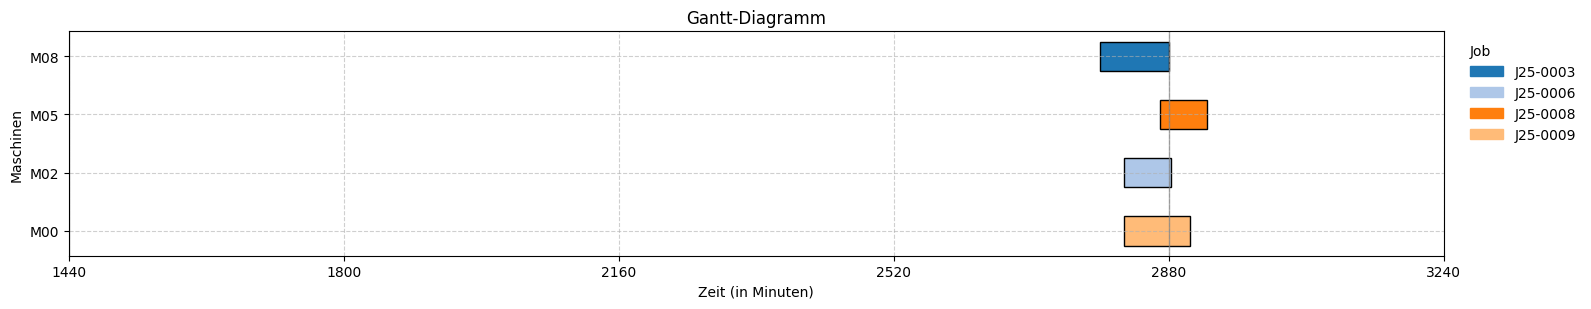

In [15]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [16]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,0,M00,76,79,1440,3660,2886.0,2962.0,-698.0,698.0
1,J25-0000,8,1,M01,69,79,1440,3660,2962.0,3031.0,-629.0,629.0
2,J25-0000,8,2,M03,76,79,1440,3660,3031.0,3107.0,-553.0,553.0
3,J25-0000,8,3,M05,51,79,1440,3660,3129.0,3180.0,-480.0,480.0
4,J25-0000,8,4,M02,85,79,1440,3660,3239.0,3324.0,-336.0,336.0
5,J25-0000,8,5,M09,11,79,1440,3660,3345.0,3356.0,-304.0,304.0
...,...,...,...,...,...,...,...,...,...,...,...,...
70,J25-0012,2,8,M09,45,1103,1440,4385,3905.0,3950.0,-435.0,435.0
71,J25-0012,2,9,M04,33,1103,1440,4385,4352.0,4385.0,0.0,0.0
72,J25-0014,4,7,M07,49,1222,1440,3315,2981.0,3030.0,-285.0,285.0


#### b) größte absolute Lateness minimieren

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **größte Abweichung** eines Jobs zur Deadline – unabhängig davon, ob der Job **zu früh oder zu spät** fertiggestellt wurde.  
Sie sorgt dafür, dass **kein Job extrem abweicht**, und behandelt **Früh- und Spätfertigstellungen gleichwertig**.

In [17]:
# Scheduling
df_schedule_b = lp_late_schedule.solve_jssp_max(
    df_jssp_current, df_jobs_times_current, solver="HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel=0.01)
df_schedule_b

BigM: 6000

Solver-Informationen:
  Maximale absolute Lateness : 0.0
  Solver-Status              : Optimal
  Anzahl Variablen           : 1393
  Anzahl Constraints         : 2608
  Laufzeit                   : ~4 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,0,M00,76,79,1440,3660,2418.0,2494.0,0.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2632.0,2701.0,0.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,2754.0,2830.0,0.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,2847.0,2898.0,0.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,2898.0,2983.0,0.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3248.0,3259.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,2020.0,2068.0,0.0,0.0
155,J25-0015,5,5,M09,72,1436,1440,2981,2140.0,2212.0,0.0,0.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2212.0,2259.0,0.0,0.0


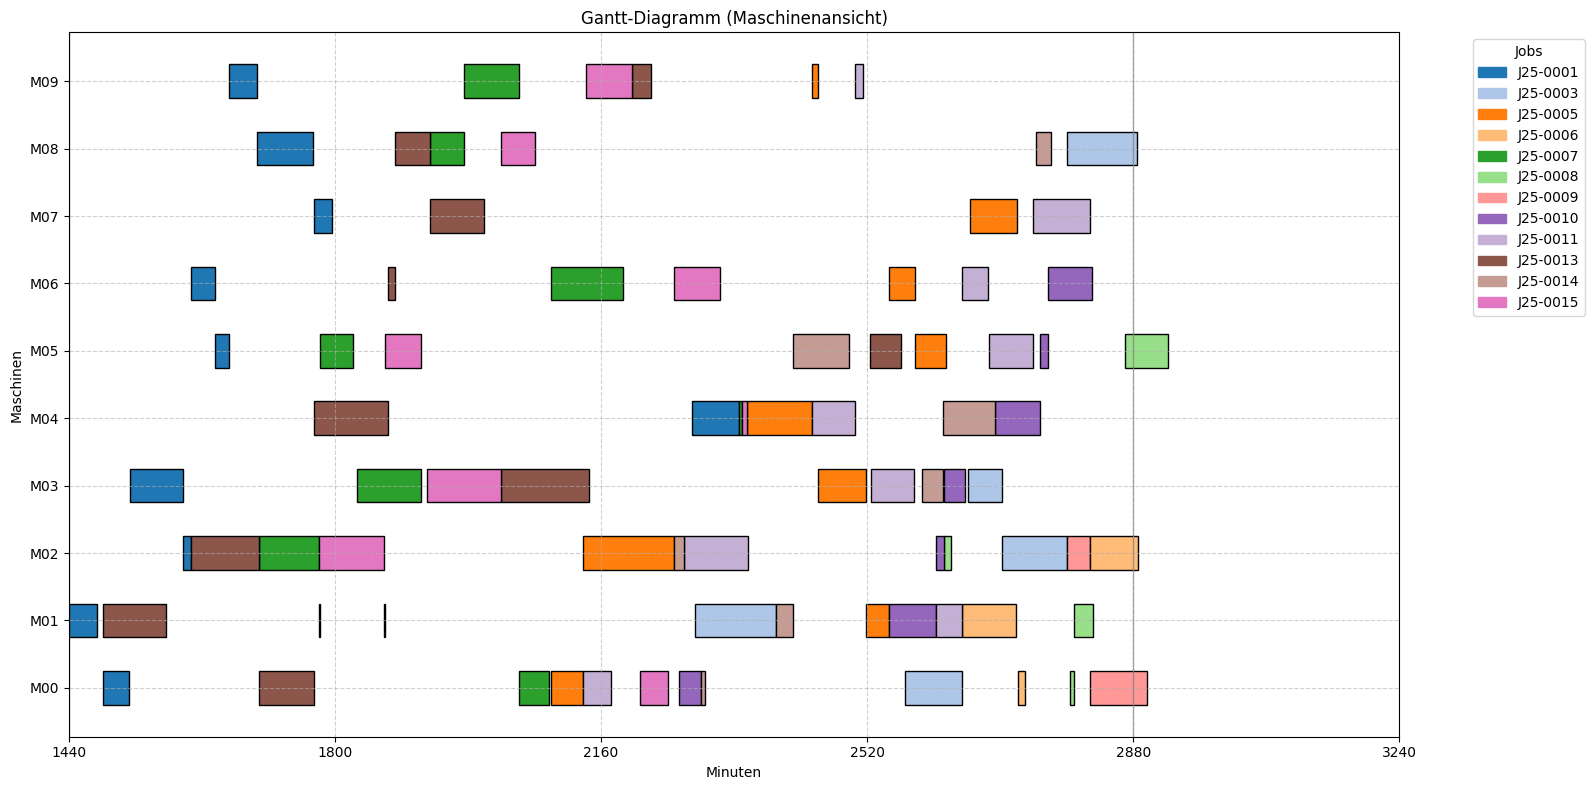

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [18]:
columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)

## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [19]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [20]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [21]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [ ]:
df_schedule_simple = lp_late_reschedule.solve_jssp_sum_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = day_start, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple

BigM: 12000


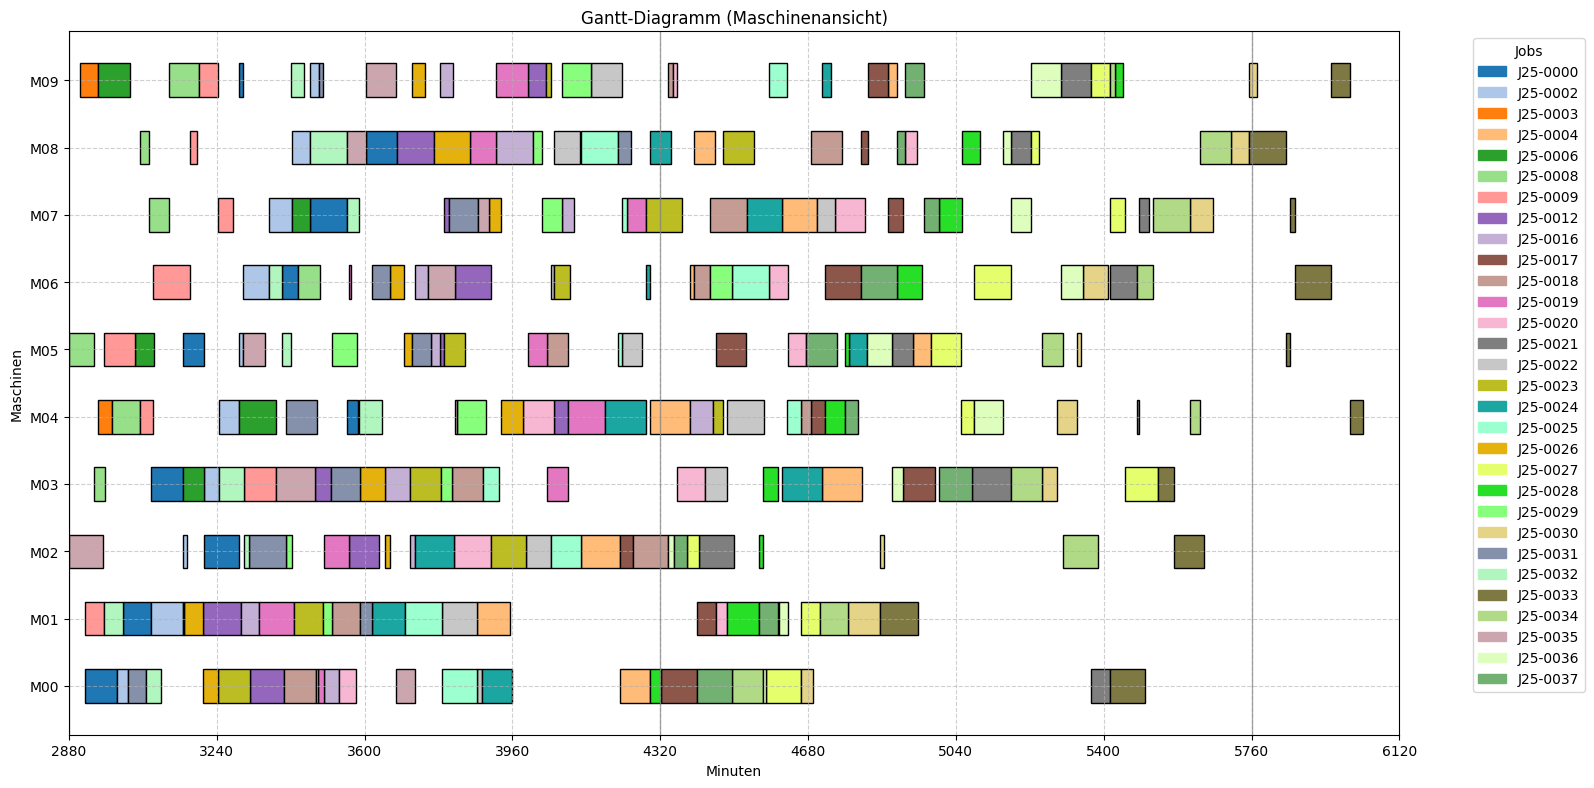

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

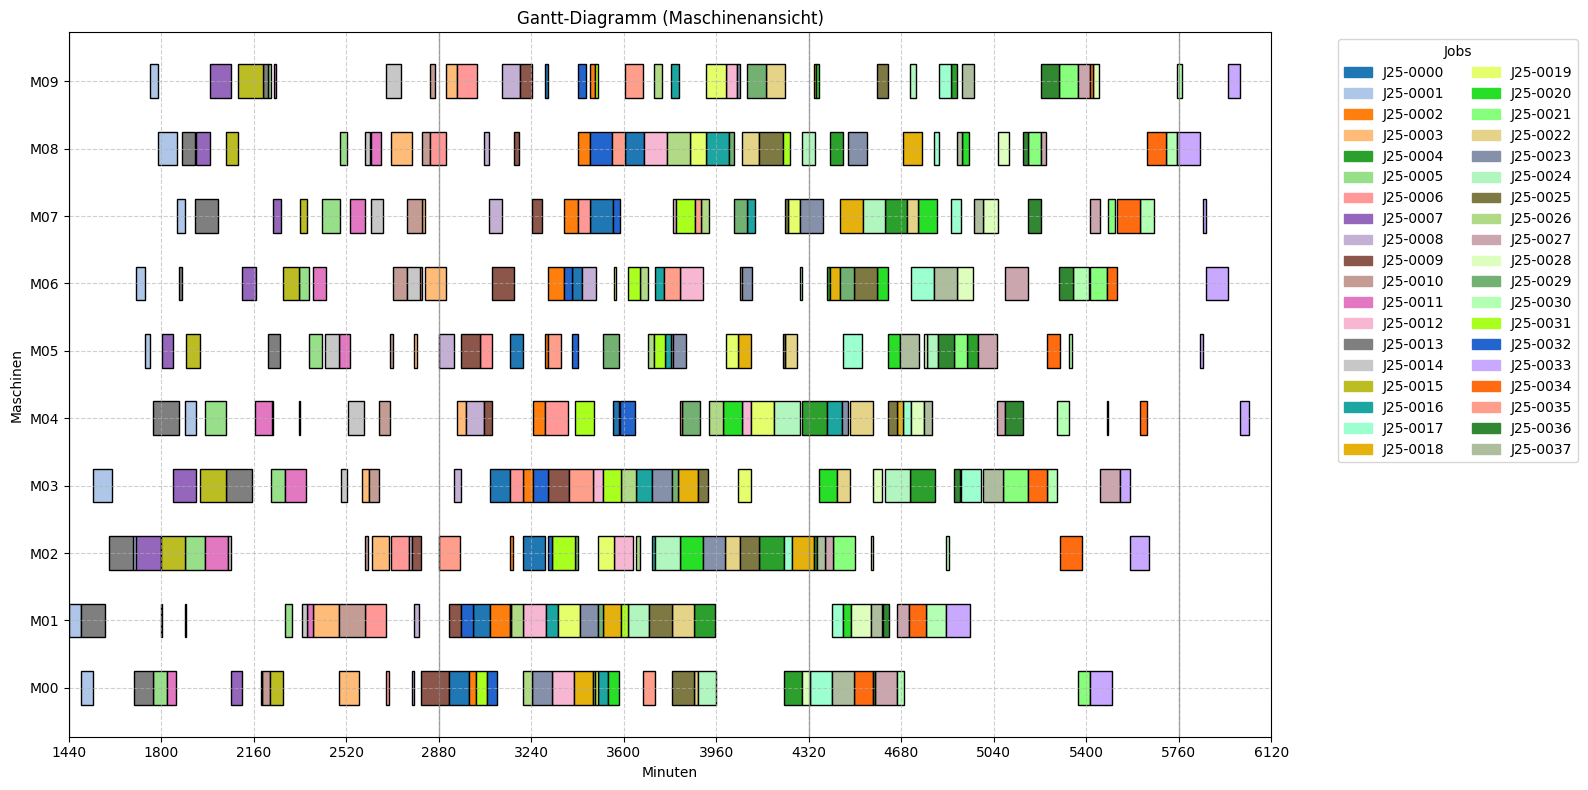

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [25]:
df_schedule_devpen = lp_late_reschedule.solve_jssp_sum_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start, solver= "HiGHS",
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen

BigM: 12000

Solver-Informationen:
  Zielfunktionswert       : 15764.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 4331
  Anzahl Constraints      : 8320
  Laufzeit                : ~900 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2920.0,2996.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2996.0,3065.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,3065.0,3141.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3149.0,3200.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3200.0,3285.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3336.0,3347.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
276,J25-0037,7,4,M04,32,2801,2880,5173,4878.0,4910.0,0.0
277,J25-0037,7,5,M06,88,2801,2880,5173,4910.0,4998.0,0.0
278,J25-0037,7,6,M08,19,2801,2880,5173,4998.0,5017.0,0.0


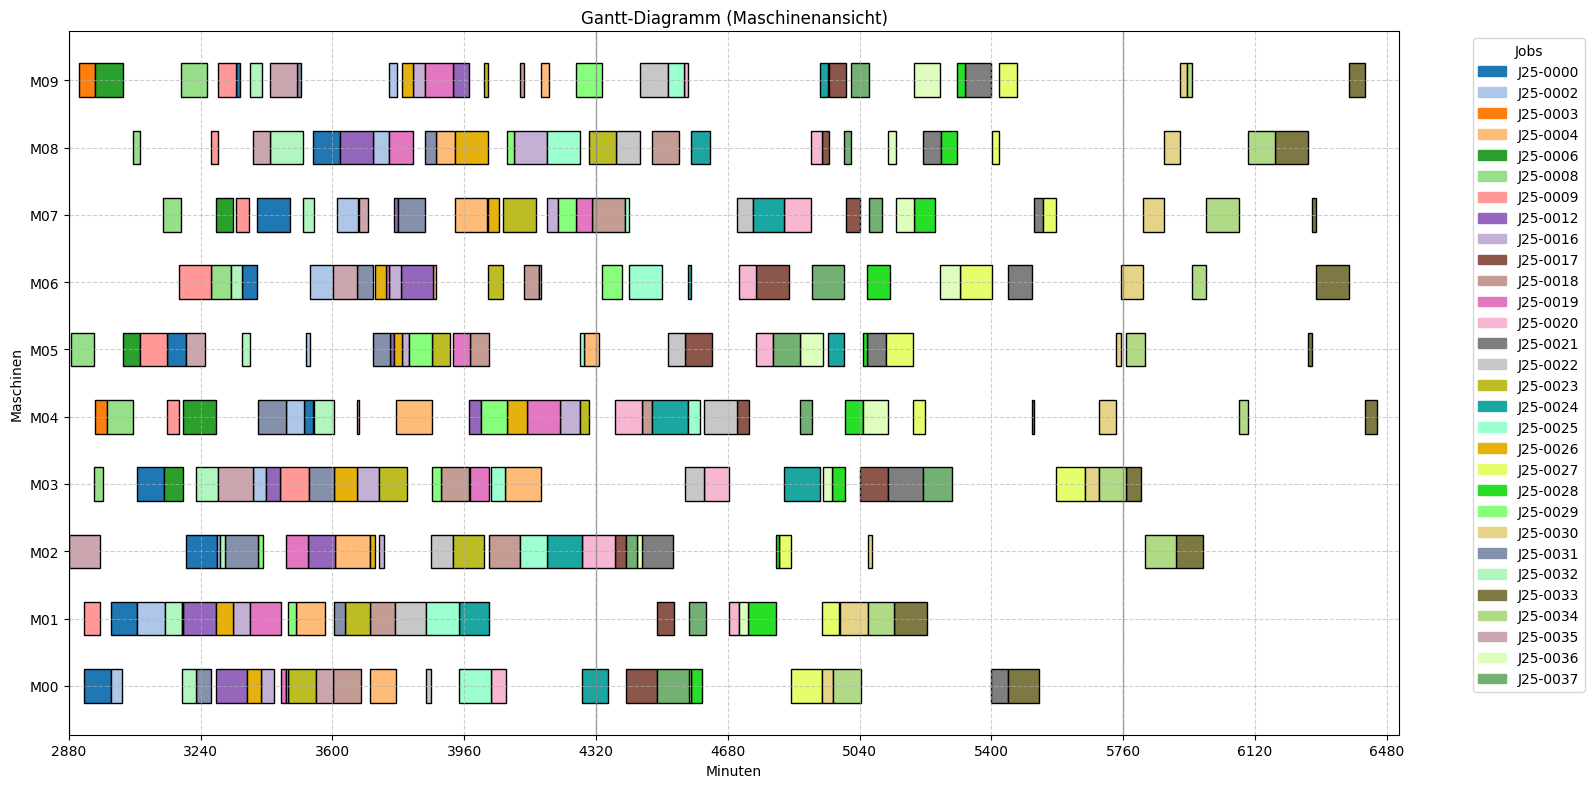

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [28]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

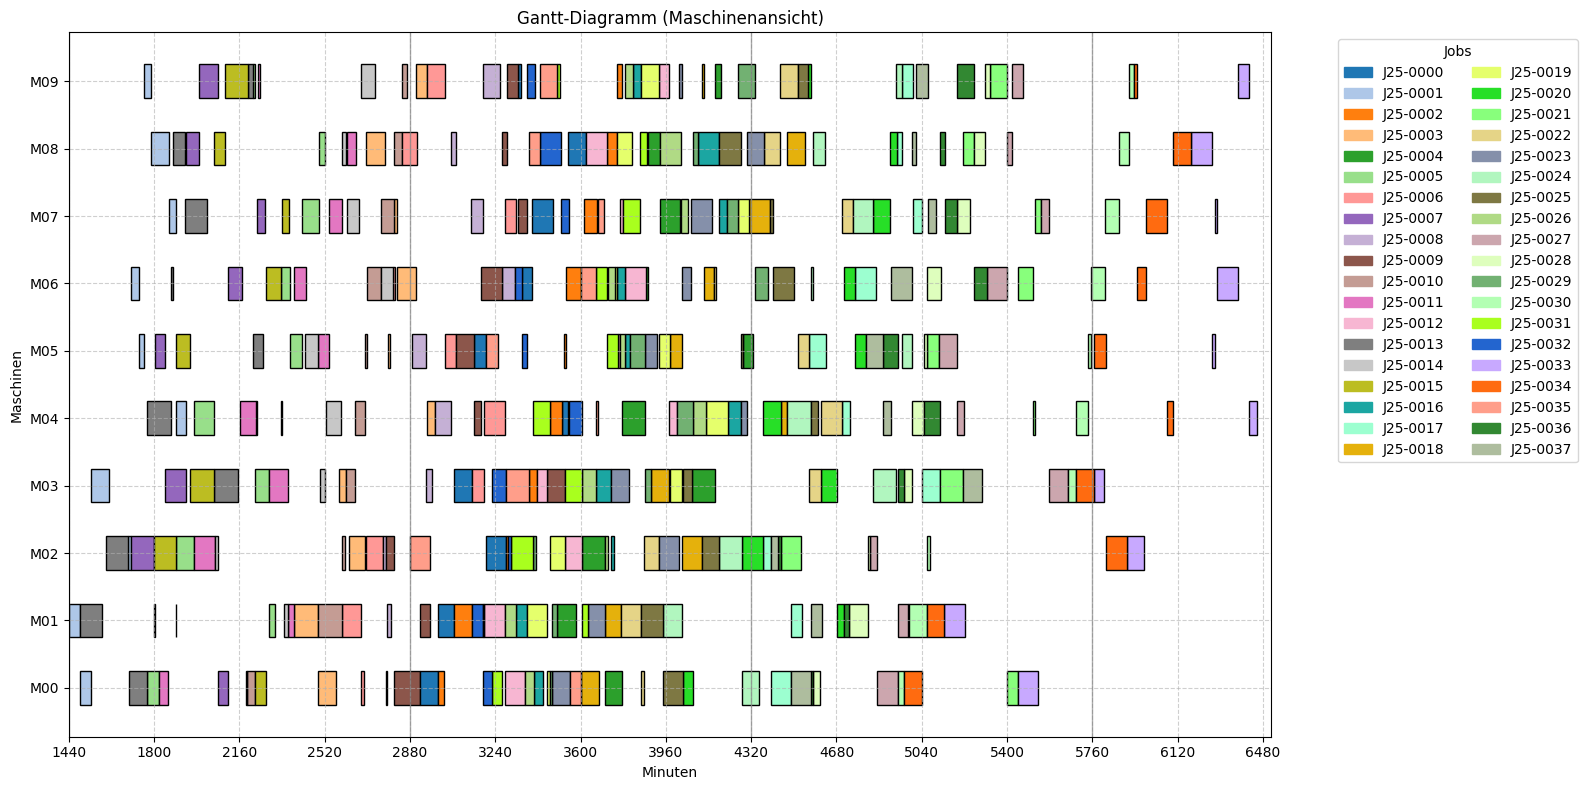

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [29]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [30]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0009, Operation 1 resumed with 40.00 min
[Day 2 00:00:00] Job J25-0003, Operation 7 resumed with 27.00 min
[Day 2 00:00:00] Job J25-0006, Operation 4 resumed with 28.00 min
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:07:00] Job J25-0008 started on M05
[Day 2 00:27:00] Job J25-0003 finished on M06 (after 27 minutes)
[Day 2 00:27:00] Job J25-0003 started on M09
[Day 2 00:28:00] Job J25-0006 finished on M08 (after 28 minutes)
[Day 2 00:40:00] Job J25-0009 finished on M00 (after 40 minutes)
[Day 2 00:40:00] Job J25-0000 started on M00
[Day 2 00:40:00] Job J25-0009 started on M01
[Day 2 01:02:00] Job J25-0008 finished on M05 (after 55 minutes)
[Day 2 01:05:00] Job J25-0003 finished on M09 (after 38 minutes)
[Day 2 01:08:00] Job J25-0008 started on M03
[Day 2 01:12:00] Job J25-0006 started on M09
[Day 2 01:12:00] Job J25-0003 started on M04
[Day 2 01:18:00] Job J25-0009 finished on M01 (after 38 minutes)
[Day 2 01:28:00] Job J25-0035 finished on M02 (after

In [31]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Routing_ID
0,J25-0000,0,M00,79,2920.0,88.0,3008.0,8.0
1,J25-0000,1,M01,79,3008.0,73.0,3081.0,8.0
2,J25-0000,2,M03,79,3081.0,77.0,3158.0,8.0
3,J25-0000,3,M05,79,3170.0,53.0,3223.0,8.0
4,J25-0000,4,M02,79,3223.0,80.0,3303.0,8.0
5,J25-0000,5,M09,79,3368.0,10.0,3378.0,8.0
...,...,...,...,...,...,...,...,...
150,J25-0035,4,M08,2726,3399.0,47.0,3446.0,5.0
151,J25-0035,5,M09,2726,3446.0,76.0,3522.0,5.0
152,J25-0035,6,M00,2726,3578.0,45.0,3623.0,5.0


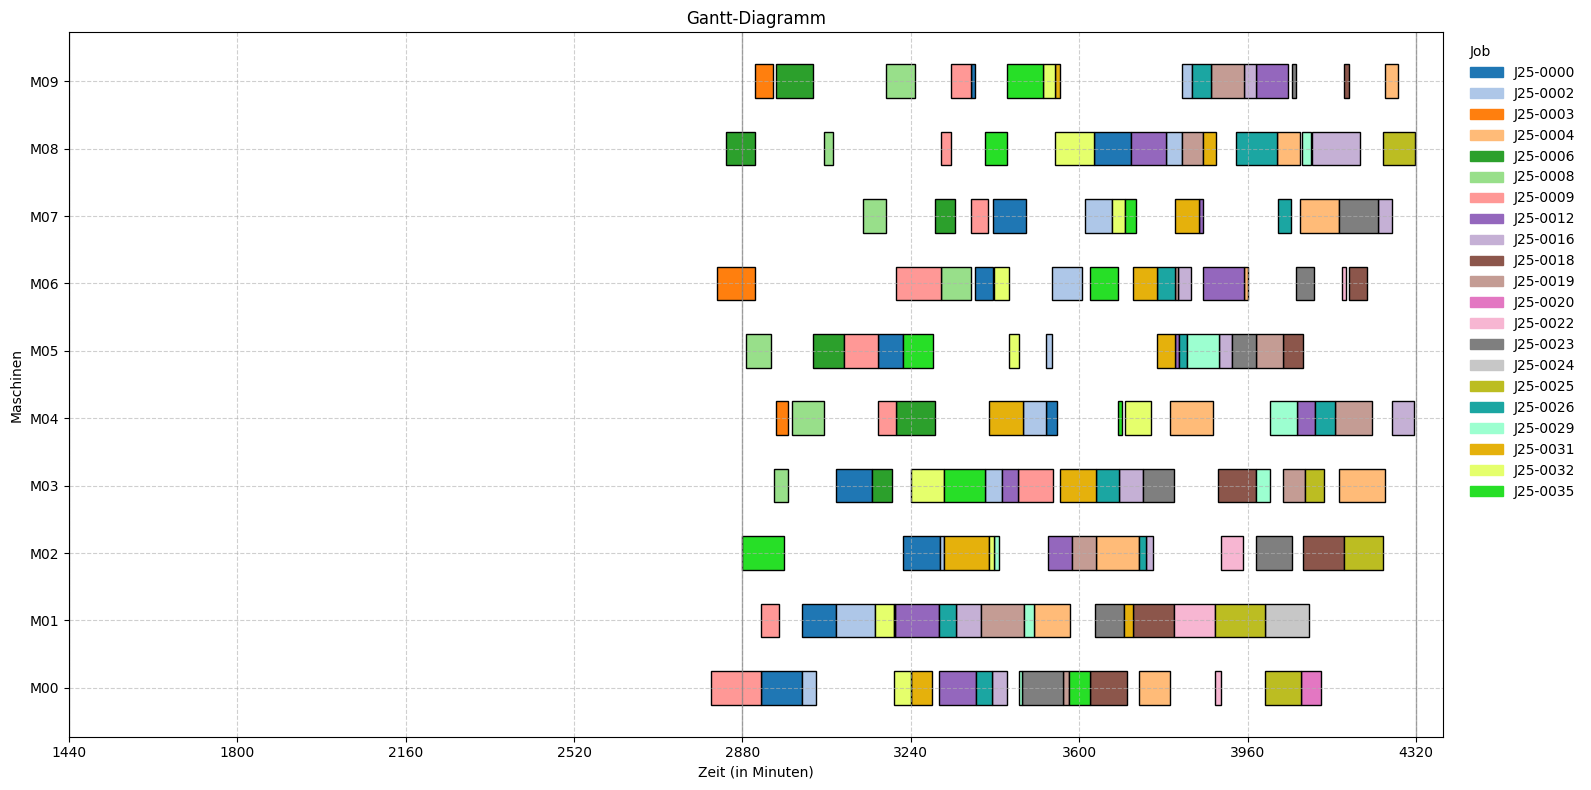

In [32]:
show.plot_gantt(df_execution2, perspective="Machine")

In [33]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0004,9,M05,287,4286.0,43,48.0,4329.0,4334.0
1,J25-0023,8,M04,2055,4315.0,26,25.0,4341.0,4340.0
2,J25-0024,1,M02,2108,4250.0,95,71.0,4345.0,4321.0
3,J25-0029,7,M07,2301,4269.0,49,53.0,4318.0,4322.0


In [34]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0001,6,0,M01,46,129,1440,2338,1440.0,1486.0,0.0
1,J25-0001,6,1,M00,37,129,1440,2338,1486.0,1523.0,0.0
2,J25-0001,6,2,M03,61,129,1440,2338,1523.0,1584.0,0.0
3,J25-0001,6,3,M02,13,129,1440,2338,1584.0,1597.0,0.0
4,J25-0001,6,4,M06,32,129,1440,2338,1597.0,1629.0,0.0
5,J25-0001,6,5,M05,21,129,1440,2338,1629.0,1650.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
89,J25-0015,5,4,M08,48,1436,1440,2981,2020.0,2068.0,0.0
90,J25-0015,5,5,M09,72,1436,1440,2981,2068.0,2140.0,0.0
91,J25-0015,5,6,M00,47,1436,1440,2981,2140.0,2187.0,0.0


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

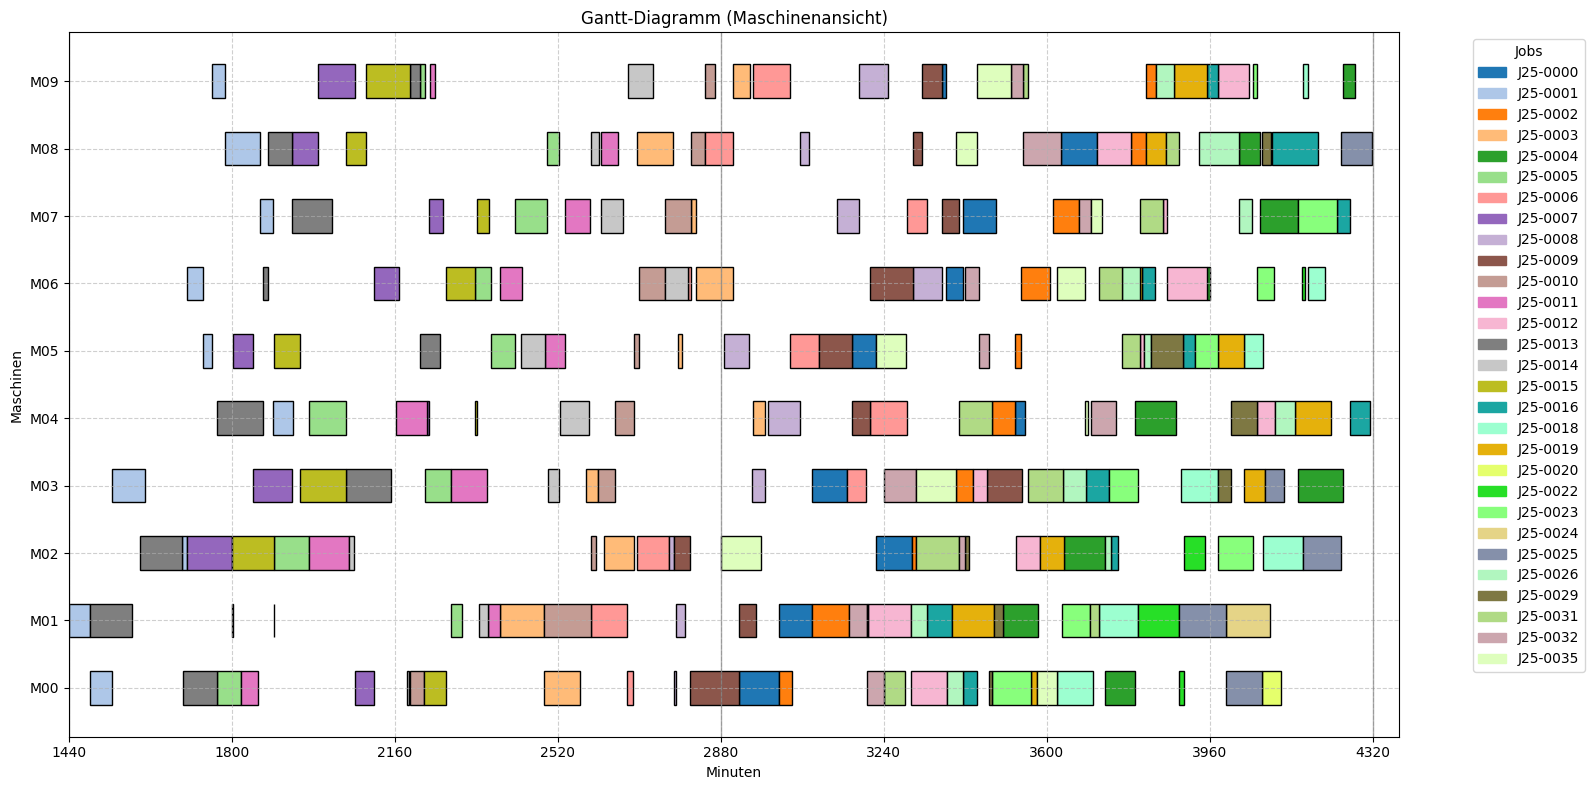

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [35]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)